# Baseline Rhythmic Assessment System

This notebook aims at the creation of a simple baseline rhythmic assessment system which exemplifies the usage of the MAST Rhythmic subset

Starting by creating some auxiliar functions to handle the stored data and functions that prepare the raw dataset to feed Machine Learning classifiers. The model features are the edit distance (aka Levenshtein distance) and the beat difference whereas the targets are the average of grades provided by annotators and binary assessments (fail or pass) according to these grades

In [1]:
import os
import numpy as np
import pip

from sklearn.datasets.base import *
from textdistance import *
from scipy.spatial.distance import *

DATA_FOLDER = "../data/"

       
### storage handlers ###
def get_audio_index(file, performance_type):
    file_path = os.path.join(DATA_FOLDER, 'Only %ss' % performance_type.capitalize(), 'list%ss' % performance_type)
    with open(file_path, 'r') as list_files:
        files = [x.strip() for x in list_files.readlines()]
        return files.index(file)
    
def get_info(index, performance_type, info_file_format):   
    file_path = os.path.join(DATA_FOLDER, 'Only %ss' % performance_type.capitalize(), info_file_format.format(performance_type.capitalize()))
    
    with open(file_path, 'r') as infos:
        info = infos.readlines()[index]
        return [int(x) for x in info.split()]

    
def beat_difference(v1, v2):
    return abs(v1.count(1) - v2.count(1))

def mean_squared_error_for_rhythm(A_bin, E_bin, Km = 25 , Ks = 0.55):
    '''
    Implementation of a MSE function following
    for rhythmic assessment purposes. The original
    algorithm is proposed by Percival et al in
    http://percival-music.ca/research/masters-percival.pdf
    '''
    def closest_value(alist, value):
        min_diff = float('inf')
        c_value = None
        
        for element in alist:
            if abs(value - element) < min_diff:
                min_diff = abs(value - element)
                c_value = element
        
        return c_value
                
        
    A = [i for i in range(len(A_bin)) if A_bin[i]]
    E = [i for i in range(len(E_bin)) if E_bin[i]]
    
    mse = 0
    
    for i in range(len(E)):
        c_val = closest_value(A, E[i])
        error = abs(c_val - E[i])
        error = np.power(error,2)/len(E)
        error = min(error, Km)
        mse+=error
    
    for i in range(len(A)):
        c_val = closest_value(E, A[i])
        error = abs(c_val - A[i])
        error = np.power(error,2)/len(A)
        error = min(error, Km)
        mse+=error
    
    return 100 - Ks * mse


def get_class_for_performance(audio_name, multiclass=True):
    annotations = []
    for (dirpath, dirnames, filenames) in os.walk(os.path.join(DATA_FOLDER, "Performances Annotations")):
        for file_name in filenames:
            if file_name == 'listfiles.txt':
                pass
            else:
                with open(os.path.join(dirpath, file_name), 'r') as annotator_file:
                    for annotation in annotator_file.readlines():
                        annotation = annotation.strip()
                        if audio_name in annotation:
                            grade = int(annotation.split()[1].split('Grade:')[1])
                            annotations.append(grade)
                            
    # the average grade across all annotations is calculated according to the following:
    # "leave the max and min value out and compute an average of the rest"
    annotations.remove(max(annotations))
    annotations.remove(min(annotations))
    average_grade = sum(annotations)/len(annotations)
    if multiclass:
        return (average_grade, np.std(annotations))
    # the binary class of a performance is 1 (accepted) if mode is 3 or higher. 0 (rejected) otherwise
    return 1 if average_grade >= 3 else 0
  
def load_rhythmic_performances():
    features = []
    target_multiclass = []
    target_binary = []
    
    DISTANCE_FUNCTIONS = [beat_difference, mean_squared_error_for_rhythm, #rhythm-based features
                          levenshtein, damerau_levenshtein, jaro, jaro_winkler, # text-based features
                          hamming, yule, matching] # vector-based features
    
    with open('../data/Performances Annotations/listfiles.txt', 'r') as list_of_files,\
         open('../data/Only Performances/listperformances', 'r') as performances_file,\
         open('../data/Only Performances/MAST Onsets [Performances] [BINS]', 'r') as performances_onsets,\
         open('../data/Only References/listreferences', 'r') as references_file,\
         open('../data/Only References/MAST Onsets [References] [BINS]', 'r') as references_onsets:        
        
        for performance in list_of_files.readlines():
            performance = performance.strip()
            index = get_audio_index(performance,'performance')
            
            performance_bins = get_info(index, 'performance', 'MAST Onsets [{}s] [BINS]')
            reference_bins = get_info(index, 'reference', 'MAST Onsets [{}s] [BINS]')   
            
            # model features
            features.append([distance_function(performance_bins, reference_bins) for distance_function in DISTANCE_FUNCTIONS])         
            
            # model targets
            target_multiclass.append(get_class_for_performance(performance))
            target_binary.append(get_class_for_performance(performance, multiclass=False))
            
    return Bunch(data=np.asarray(features), target_multiclass=np.asarray(target_multiclass), target_binary=np.asarray(target_binary))   

Next, we use the prepared data to train/test a Logistic Regression model for binary classification and a Linear Regression model for checking the mean average error. We are using a 5-fold cross validation (i.e. test size: 20%). The learning curves ar mean error are shown below.

################ Consistency of Annotations ################
Average of standard deviations: 0.493443123979
Max standard deviation: 0.979795897113
Performances with no standard deviation: 38

################ Linear Regression Model for grade estimation ################
Mean absolute error: Dumb Estimator (Only Grades 2) -> 1.1275
Mean absolute error: Dumb Estimator (Only Grades 3) -> 0.7175
Mean absolute error: Dumb Estimator (Random Grades) -> 1.2575
Mean absolute error: MAST Estimator (5-fold cross validation) -> 0.58554281801


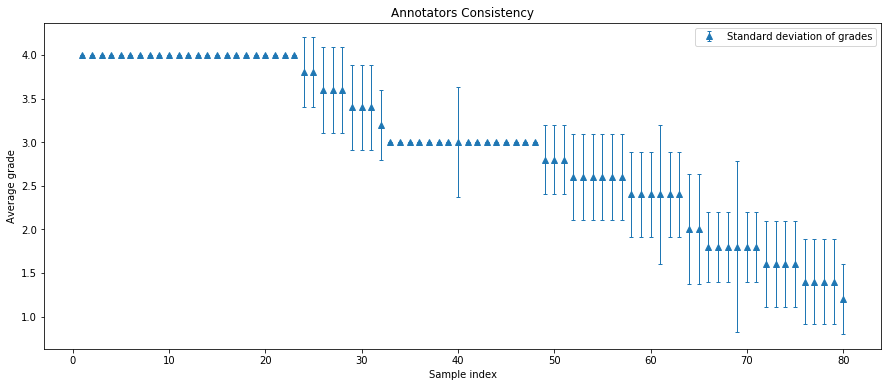

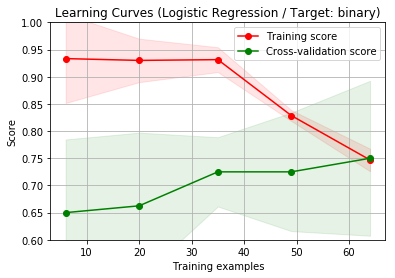

In [3]:
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import learning_curve, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs)  
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# loading rhythmic dataset
mast = load_rhythmic_performances()
X, y_b, y_m = mast.data, mast.target_binary, mast.target_multiclass

y_m = sorted(y_m, key=lambda i: (float(i[0])), reverse=True)

x = np.arange(1, len(mast.target_multiclass)+ 1)
y = [y_m[i][0] for i in range(len(y_m))]
e = np.array([y_m[i][1] for i in range(len(y_m))])

non_zero_stdevs = [x for x in e if x > 0]
print("################ Consistency of Annotations ################")
print("Average of standard deviations:", sum(non_zero_stdevs)/len(non_zero_stdevs))
print("Max standard deviation:", max(non_zero_stdevs))
print("Performances with no standard deviation:", len(e) - np.count_nonzero(e))
print()


plt.figure(figsize=(15,6))
plt.title("Annotators Consistency")
plt.ylabel("Average grade")
plt.xlabel("Sample index")
error_bar = plt.errorbar(x, y, e, marker='^', capsize=2, elinewidth=1, markeredgewidth=1,label="Standard deviation of grades", ls='none')
plt.legend()

# setting up a 5-fold cross validation for estimators
cv = KFold(n_splits=5, shuffle=True, random_state=0)
title = r"Learning Curves (Logistic Regression / Target: binary)"

logit_reg_estimator = LogisticRegression()

plot_learning_curve(logit_reg_estimator, title, X, y_b, (.6, 1), cv=cv)


linear_reg_estimator = LinearRegression()
linear_reg_estimator.fit(X, mast.target_multiclass[:,0])
# fitting dumb model which assigns 2, 3 and random values to all performances to be estimated
base_random_grades = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4]

mean_absolute_errors_random = []
mean_absolute_errors_only_twos = []
mean_absolute_errors_only_threes = []

for train_index, test_index in cv.split(X):
    y_test = mast.target_multiclass[:,0][test_index]
    
    np.random.shuffle(base_random_grades)
    mean_absolute_errors_random.append(mean_absolute_error(y_test, base_random_grades)) 
    
    predictions_all_two = np.repeat(2, len(y_test))
    mean_absolute_errors_only_twos.append(mean_absolute_error(y_test, predictions_all_two))
    
    predictions_all_three = np.repeat(3, len(y_test))    
    mean_absolute_errors_only_threes.append(mean_absolute_error(y_test, predictions_all_three)) 
    
# running cross validation over our dataset
cross_val_errors = cross_val_score(linear_reg_estimator, X, mast.target_multiclass[:,0], scoring='neg_mean_absolute_error', cv=cv)

print("################ Linear Regression Model for grade estimation ################")
print("Mean absolute error: Dumb Estimator (Only Grades 2) ->", sum(mean_absolute_errors_only_twos)/len(mean_absolute_errors_only_twos))
print("Mean absolute error: Dumb Estimator (Only Grades 3) ->", sum(mean_absolute_errors_only_threes)/len(mean_absolute_errors_only_threes))
print("Mean absolute error: Dumb Estimator (Random Grades) ->", sum(mean_absolute_errors_random)/len(mean_absolute_errors_random))
print("Mean absolute error: MAST Estimator (5-fold cross validation) ->", abs(sum(cross_val_errors)/len(cross_val_errors)))